# Phase IV - Zomato delivery app customer characteristic analysis

## Table of Contents
1. Introduction
2. Data Collection and Cleaning
3. Data Description
4. Preregistration of Analysis
5. Exploratory Data Analysis
6. Evaluation of Significance
7. Interpretations and Conclusion
8. Limitations

## Introduction 
In this project, we delve into an intriguing exploration of customer behavior in the food delivery industry. We aim to uncover a potential connection between various demographic factors, such as age, gender, marital status, occupation, education level, family size, and monthly income, with the cost of food orders. This investigation is not only relevant to stakeholders in the food delivery sector but also to anyone interested in the nuances of consumer behavior (something all of our groupmates have in common).

Understanding how different demographic variables influence food order costs could offer valuable insights into broader consumer behavior trends. This is crucial in an era where predicting consumer preferences and behaviors is a key challenge and opportunity for businesses. For instance, revealing that certain demographics are inclined to place more expensive orders could inform targeted marketing strategies and menu adjustments. Similarly, exploring the relationship between income and spending patterns in food delivery could contribute to wider economic studies.

For this project we collected 3 different data tables from kaggle. All of the data tables pertain to different types of data on the Zomato Food Delivery platform, a platform used in India. The first of the data tables, the orders data table includes information on specific orders that occured on the zomato platform. Each order entry has a date, sales quantity, sales amount, currency of order, the user id associated with the order, and the restaurant id associated with the order. The next table was the restaurant table. Each entry in this table has an id identifying the restaurant, the name of the restaurant, the city of the restaurant, the restaurant's rating, the number of ratings the restaurant has, the estimated cost per person for that restaurant, the cuisine, the license number, the restaurant's link, the address, and a json link to the menu. Finally the third table we used was the users_df table. Each entry in this field has a user_id, a name of the user, an email, a password, the gender the marital status, occupation, income, educational qualifications, and family size (including the customer).

**Our research interests lead us to the following Research Questions:**
- **(1) How do various customer demographics collectively predict the total order cost?**
- **(2) How do restaurant characteristics impact the total order cost when accounting for multiple variables simultaneously?**


## Data Collection and Cleaning

### Imports

In [249]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score

In [250]:
final_merged_df = pd.read_csv('final.csv')

### Final Cleaned Dataframe:

In [251]:
final_merged_df.head()

,order_id,order_date,number_items_ordered,total_order_cost,currency,c_id,r_id,c_name,c_age,c_gender,...,c_marital_status_Single,c_occupation_Employee,c_occupation_House wife,c_occupation_Self Employeed,c_occupation_Student,c_education_level_Graduate,c_education_level_Ph.D,c_education_level_Post Graduate,c_education_level_School,c_education_level_Uneducated
0,2,2018-04-06,1,875,INR,5321,158203,Donald Anderson,24,1,...,0,1,0,0,0,0,0,1,0,0
1,1424,2020-03-23,8,17495,INR,5321,47241,Donald Anderson,24,1,...,0,1,0,0,0,0,0,1,0,0
2,3,2018-04-11,1,583,INR,21343,187912,Scott Cruz,22,1,...,1,0,0,0,1,0,0,1,0,0
3,81018,2018-05-11,51,50991,INR,33246,146339,Stephanie Robinson,24,0,...,1,1,0,0,0,1,0,0,0,0
4,8,2017-11-27,35,19213,INR,31017,156602,Donald Campbell,29,1,...,1,1,0,0,0,1,0,0,0,0


### Cleaning Summary:
To clean our data, we made the following basic changes:
- For order_date, there were no changes needed in terms of invalid entries; however to abide by American datetime conventions, we switched the format to mm/dd/yyyy. 
- For total_order_cost, we dropped all orders that had a total order cost of less than 1 rupee. While in theory there are reasons for why an order could be less than 1 rupee, we don't have data like discounts and vouchers that would allow us to justify the total
- For currency, we converted all currency entries of INR\r to just INR for continuity. According to the documentation they mean the same exact thing. We also dropped the very few values that were represented in USD.

We also made more complex changes to our data to allow for better data analyses:
- For c_gender, we used binary encoding to represent males as 1 and female as 0. This allowed us to convert the categorical data into numerical data to be used later.
- For c_monthly_income, because the originally provided data lumped monthly income into income brackets (which were No Income, Below Rs. 10000, 10001 to 25000, 25001 to 50000, More than 50000) we arbitratily assigned No Income to 0, the defined ranges to their median values (Below Rs. 10000 => 5000, 10001 to 25000 => 17500, 25001 to 50000 => 37500), and then assigned  65000 to More than 500000 because the constant difference when subtracting each of the values is 7,500 added to the difference of the previous two differences so we just added 7500 to 37500 - 17500 and added that to 50,000 to get 65000. All in rupees.
- For r_number_of_ratings, the total number of ratings received by the restaurant. Even though these are buckets of number of ratings (i.e. 10k+) we took the lower bound. Also there is no double counting in this dataset (i.e. all of the buckets are mutually exclusive).
- For r_rating, we converted these values to floats.

These 3 variables were one hot encoded as binary. This is important because it will allow us to do linear regression on these categorical variables:
- c_marital_status indicates marital status (Married, Prefer not to say, Single).
- c_occupation indicates the occupation of the customer (Employee, House wife, Self Employeed, Student).
- c_education_level represents the education level of the customer (Graduate, Ph.D, Post Graduate, School, Uneducated).

## Data Description
Here, we will provide a detailed description of the dataset. This will include the types of variables, the range of values they take, and any other relevant information.

#### What are the observations (rows)?
- In our final data set, each observation represents an order from a restarant. For each observation, there is data on the order itself (like the order date and number of items in the order), data on customer details (like the customer's age, gender, income), and data on the restaurant the order came from (like the restaraurant's rating, what city it is in, etc).

#### What are the attributes (columns)?
- ##### Order Details
    - order_id (int64): A unique identifier for each order.
    - order_date (object): The date on which the order was placed.
    - number_items_ordered (int64): The total number of items included in the order.
    - total_order_cost (int64): The total cost of the order. All in rupees.
    - currency (object): The type of currency used for the transaction

- ##### Customer Information
    - c_id (int64): A unique identifier for each customer.
    - c_name (object): The name of the customer.
    - c_age (int64): The age of the customer.
    - c_gender (int64): The gender of the customer, encoded to 1 for males, and 0 for females
    - c_monthly_income (int64): The customer's monthly income. We arbitratily assigned No Income to 0, the defined ranges to their median values (Below Rs. 10000 => 5000, 10001 to 25000 => 17500, 25001 to 50000 => 37500), and then assigned  65000 to More than 500000.
    - c_family_size (int64): The size of the customer's family (including the customer in the tally.
    - c_marital_status (3 columns, all int64): Indicating marital status (Married, Prefer not to say, Single), one-hot encoded as binary.
    - c_occupation (4 columns, all int64): Indicating the occupation of the customer (Employee, House wife, Self Employeed, Student), one-hot encoded as binary.
    - c_education_level (5 columns, all int64): Representing the education level of the customer (Graduate, Ph.D, Post Graduate, School, Uneducated), one-hot encoded as binary.

- ##### Restaurant Details
    - r_id (int64): A unique identifier for each restaurant.
    - r_name (object): The name of the restaurant.
    - r_city (object): The city where the restaurant is located.
    - r_rating (float64): The rating of the restaurant
    - r_number_of_ratings (int64): The total number of ratings received by the restaurant.
    - r_average_per_head_cost (int64): The average cost per person at the restaurant. All in rupees.

- #### Why was this dataset created?
    - The dataset was created to explore the relationship between various demographic factors (like age, gender, marital status, occupation, education level, family size, and monthly income) and the cost of food orders. This investigation aims to provide insights into broader consumer behavior trends, which is crucial for businesses in predicting consumer preferences and behaviors.

- #### Who funded the creation of the dataset?
    - These dataset were created and funded by a user on Kaggle.

- #### What processes might have influenced what data was observed and recorded and what was not?
    - The data selection is to be influenced by the research objective of understanding the relationship between customer demographics and order costs. Factors like the availability of data on Kaggle, the relevance to the research questions, and the scope of the Zomato Food Delivery platform would have influenced the data observed and recorded.

- #### What preprocessing was done, and how did the data come to be in the form that you are using?
    - The information on the Zomato platform and the focus on customer demographics and restaurant characteristics. The choice of variables (like order cost, user demographics, restaurant details) suggests an intent to understand spending patterns in relation to these factors.

- #### If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?
    - In general, data on platforms like Kaggle is often anonymized and aggregated for research purposes, and users might be aware of potential data usage for analysis as part of the terms of service of the platform.

- #### Where can your raw source data be found, if applicable? Provide a link to the raw data (hosted on Github, in a Cornell Google Drive or Cornell Box). 
    - The raw source data was obtained from Kaggle, specifically pertaining to the Zomato Food Delivery platform. Raw data can be found at the bottom of this document under "references".
    
Links to Data:

Source For orders.csv: https://www.kaggle.com/datasets/anas123siddiqui/zomato-database?select=orders.csv

Source For restaurant.csv: https://www.kaggle.com/datasets/anas123siddiqui/zomato-database?select=restaurant.csv

Source For users.csv: https://www.kaggle.com/datasets/anas123siddiqui/zomato-database?select=users.csv


## Preregistration of Analyses
Here, we will outline the specific analyses we plan to conduct to test our hypotheses. This includes the details of the linear regression models and the variables involved.


##### **Hypothesis 1: Demographic Factors Influencing Order Cost**
* Hypothesis: We hypothesize that specific demographic characteristics, such as age, gender, marital status, occupation, education level, income level, and family size, significantly influence the total order cost. 
* Analysis Approach: We will utilize linear regression to assess the impact of various demographic variables (age, gender, marital status, occupation, education level, and family size) on the total order cost. The model will test whether the coefficients for these variables, such as β_gender, β_marital status, β_occupation, β_education level, β_income level, and β_family size, are significantly greater than zero. A positive coefficient would indicate that these factors contribute to higher order costs, while a negative coefficient would contribute to one that is lower.

##### **Hypothesis 2: Influence of Restaurant Characteristics on Order Cost**
* Hypothesis Statement: We hypothesize that certain characteristics of a restaurant, such as its rating, average cost per head, and the number of ratings it has received, positively impact the total order cost.
* Analysis Approach: A linear regression model will be applied where the predictor variables are the restaurant's rating, average per head cost, and the number of ratings. The dependent variable in this model is the total order cost. The model will assess the significance and magnitude of the coefficients for each predictor variable, such as β_rating, β_average per head cost, and β_number of ratings. A significant coefficient for these variables would suggest that they play a substantial role in determining the order costs in a restaurant. This analysis aims to understand how the perceived quality and popularity of a restaurant, as indicated by its rating and number of ratings, along with the average spending per head, correlate with the total expenditure by customers.

## Exploratory Data Analysis (EDA)
In this section, we will conduct a preliminary exploration of the data through various visualizations and summary statistics to uncover initial insights and patterns.

### Basic analysis of total_order_cost:

In [252]:
mean_cost = final_merged_df['total_order_cost'].mean()
median_cost = final_merged_df['total_order_cost'].median()
max_cost = final_merged_df['total_order_cost'].max()
min_cost = final_merged_df['total_order_cost'].min()
std_dev_cost = final_merged_df['total_order_cost'].std()

print("Average order cost (in rupees):", mean_cost)
print("Median order cost (in rupees):", median_cost)
print("Maximum order cost (in rupees):", max_cost)
print("Minimum order cost (in rupees):", min_cost)
print("Standard deviation of order cost:", std_dev_cost)

Average order cost (in rupees): 6997.273247120298
Median order cost (in rupees): 565.0
Maximum order cost (in rupees): 1492435
Minimum order cost (in rupees): 5
Standard deviation of order cost: 31942.505536199402


### Define Functions:

In [253]:
def plot_generalized_bar(data, title, xlabel, ylabel,
                         figsize=(8, 6), custom_labels=None):
    values = data.values
    labels = [str(label) for label in data.index] if custom_labels is None else custom_labels
    plt.figure(figsize=figsize)
    plt.bar(labels, values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.autoscale(enable=True, axis='x')
    plt.show()

def plot_scatter(x, y, title, xlabel, ylabel, figsize=(12, 10)):
    plt.figure(figsize=figsize)
    plt.scatter(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

The functions above allow us to make multiple plots easily, by simply calling these functions. The first function uses the parameters data, a title for the graph, and xlabel and y label for the axes labels. We will use this to make bar charts. The second function takes in the parameters of x and y data, a title for the graph, and xlabel and ylabel for the axes labels. We will use this to make scatter plots

### Let's look at customer data:

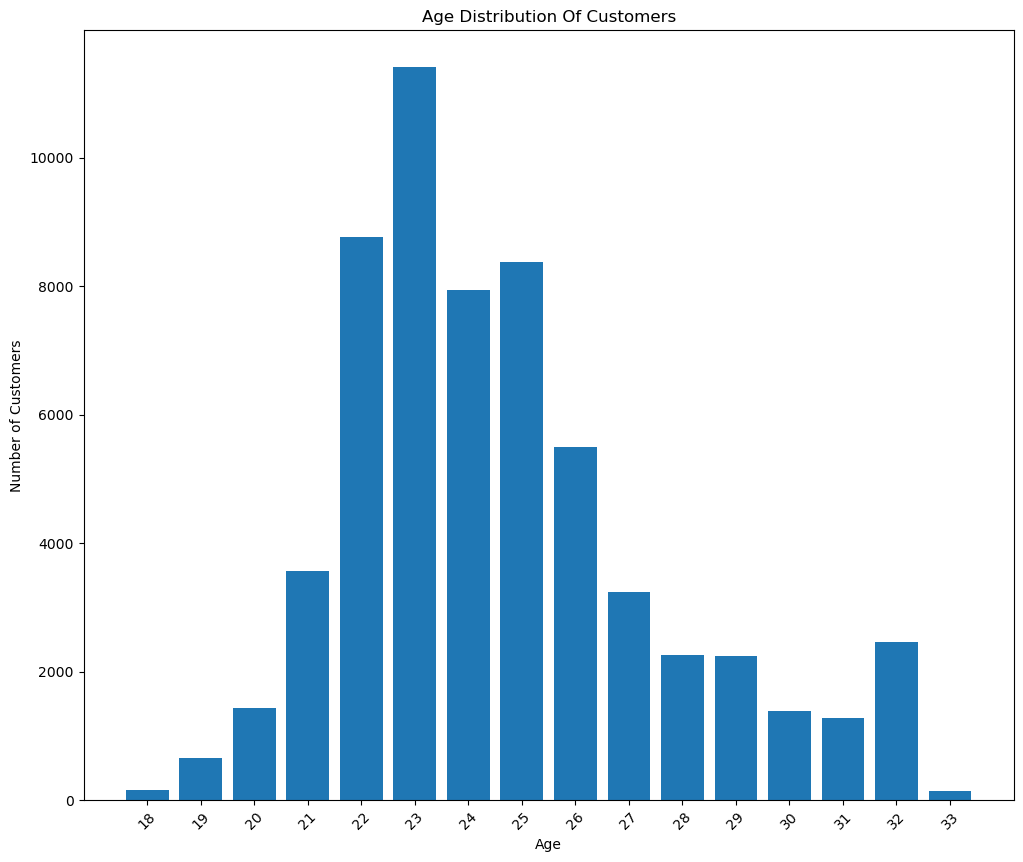

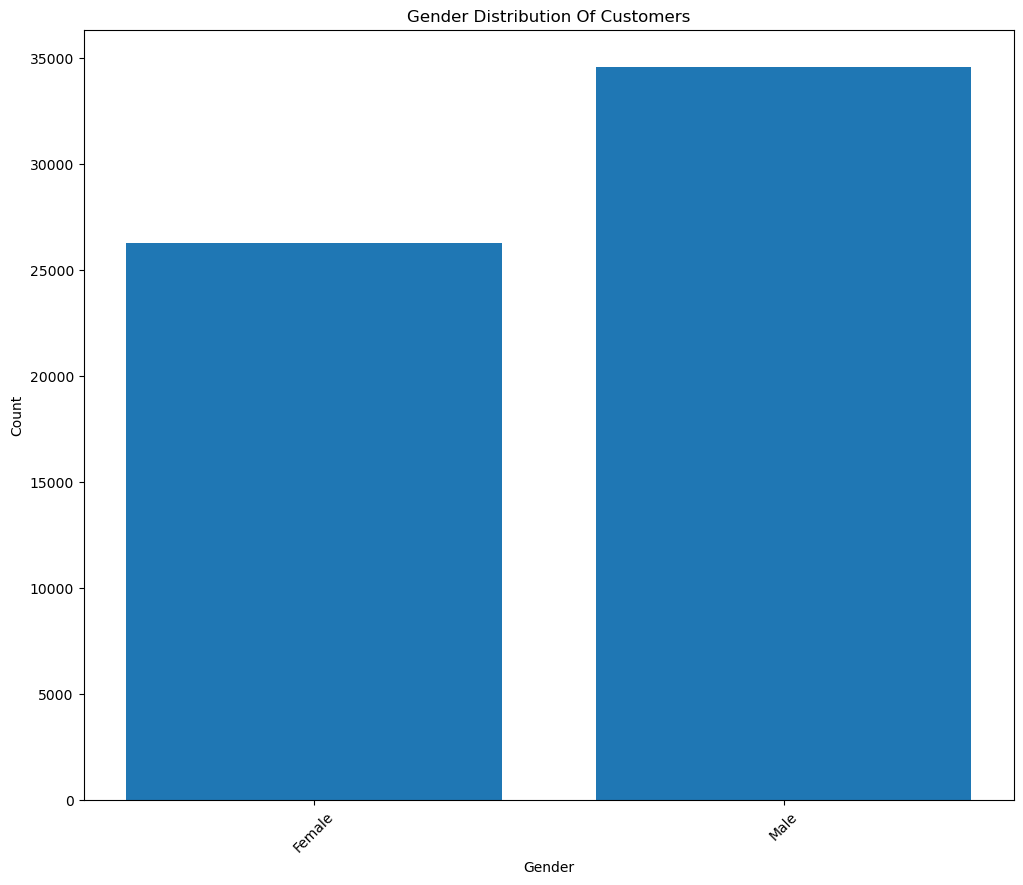

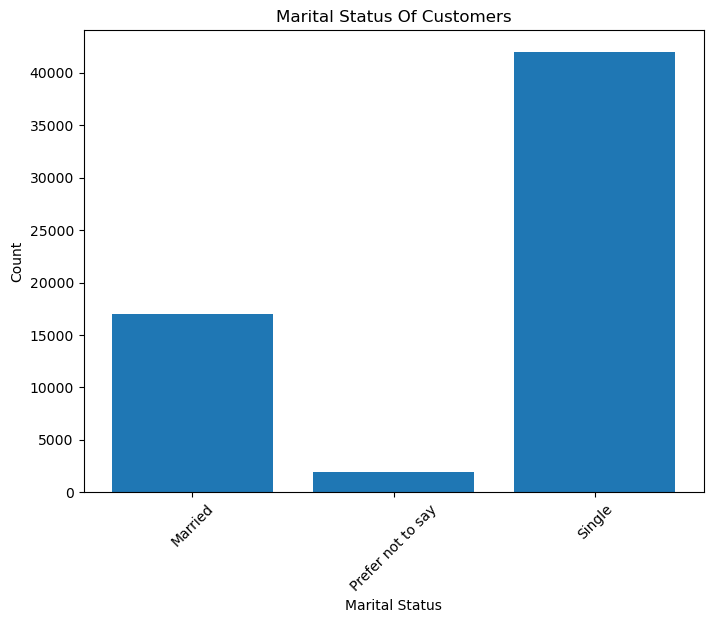

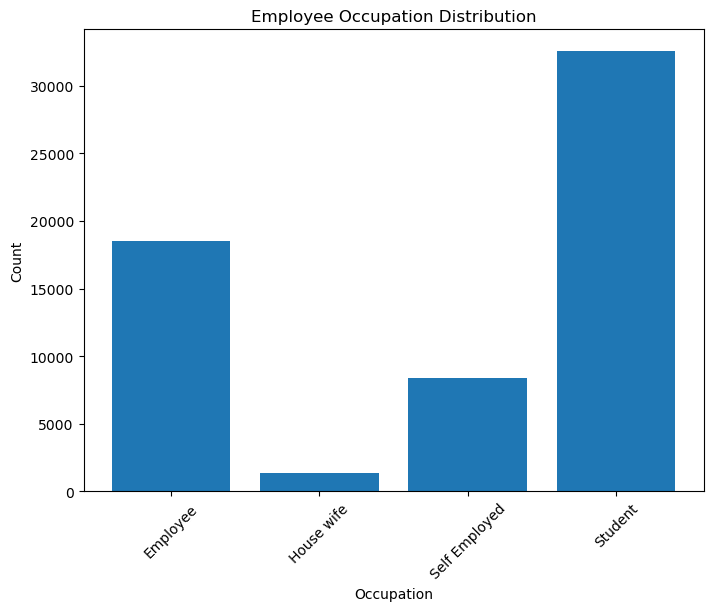

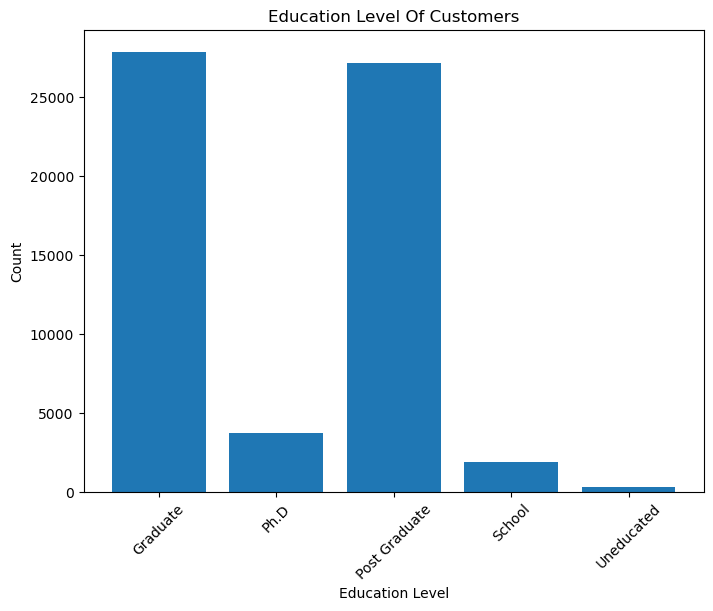

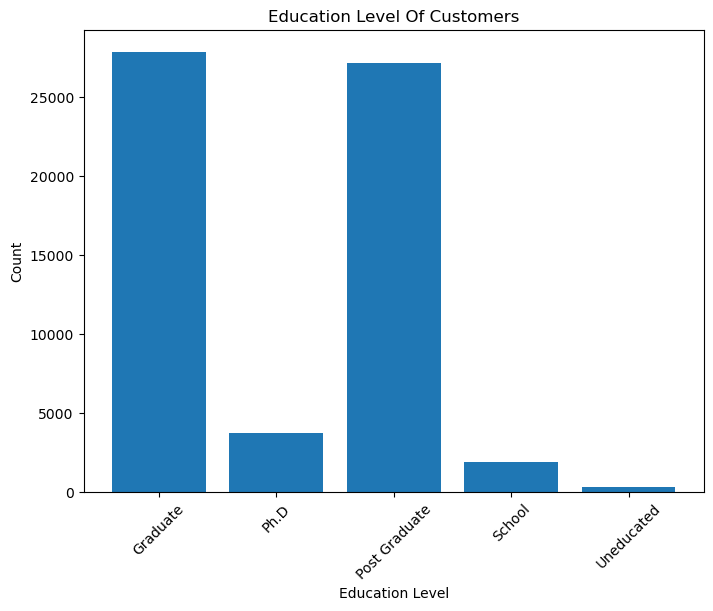

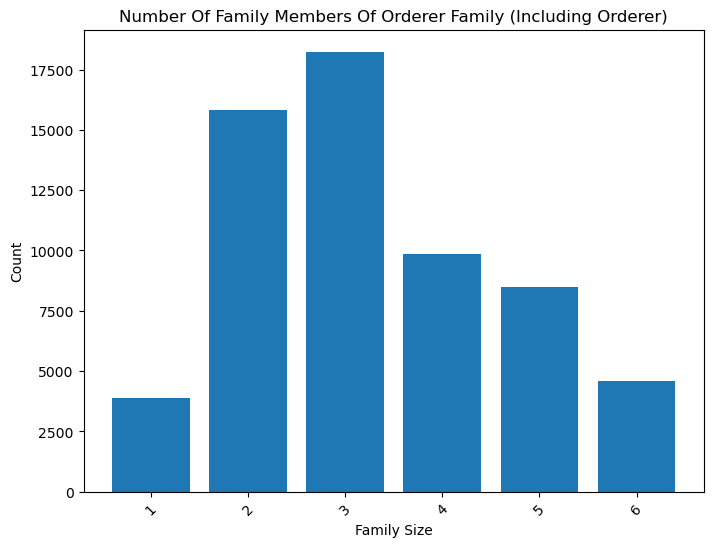

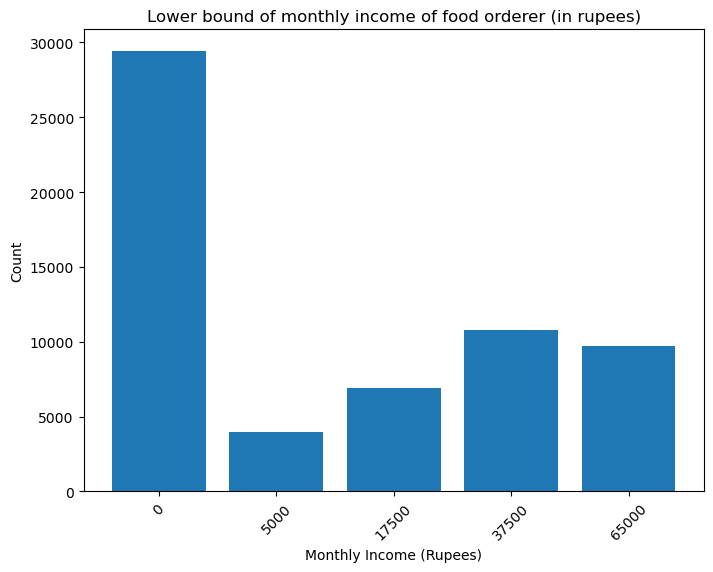

In [254]:
plot_generalized_bar(final_merged_df.groupby('c_age').size(),
                     "Age Distribution Of Customers", "Age",
                     "Number of Customers", figsize=(12, 10),
                     custom_labels=None)
plot_generalized_bar(final_merged_df.groupby('c_gender').size(),
                     "Gender Distribution Of Customers", "Gender",
                     "Count", figsize=(12, 10), custom_labels=['Female','Male'])

marital_status_counts = {
    'Married': final_merged_df['c_marital_status_Married'].sum(),
    'Prefer not to say': final_merged_df['c_marital_status_Prefer not to say'].sum(),
    'Single': final_merged_df['c_marital_status_Single'].sum()
}
plot_generalized_bar(pd.Series(marital_status_counts),
                     "Marital Status Of Customers",
                     "Marital Status", "Count")

occupation_counts = {
    'Employee': final_merged_df['c_occupation_Employee'].sum(),
    'House wife': final_merged_df['c_occupation_House wife'].sum(),
    'Self Employed': final_merged_df['c_occupation_Self Employeed'].sum(),
    'Student': final_merged_df['c_occupation_Student'].sum()
}
plot_generalized_bar(pd.Series(occupation_counts),
                     "Employee Occupation Distribution",
                     "Occupation", "Count")

education_level_counts = {
    'Graduate': final_merged_df['c_education_level_Graduate'].sum(),
    'Ph.D': final_merged_df['c_education_level_Ph.D'].sum(),
    'Post Graduate': final_merged_df['c_education_level_Post Graduate'].sum(),
    'School': final_merged_df['c_education_level_School'].sum(),
    'Uneducated': final_merged_df['c_education_level_Uneducated'].sum()
}
plot_generalized_bar(pd.Series(education_level_counts),
                     "Education Level Of Customers",
                     "Education Level", "Count")


education_level_counts = {
    'Graduate': final_merged_df['c_education_level_Graduate'].sum(),
    'Ph.D': final_merged_df['c_education_level_Ph.D'].sum(),
    'Post Graduate': final_merged_df['c_education_level_Post Graduate'].sum(),
    'School': final_merged_df['c_education_level_School'].sum(),
    'Uneducated': final_merged_df['c_education_level_Uneducated'].sum()
}
plot_generalized_bar(pd.Series(education_level_counts),
                     "Education Level Of Customers",
                     "Education Level", "Count")


family = final_merged_df.groupby('c_family_size').size()
plot_generalized_bar(family,
                     "Number Of Family Members Of Orderer Family (Including Orderer)",
                     "Family Size", "Count")


m_income = final_merged_df.groupby('c_monthly_income').size()
plot_generalized_bar(m_income,
                     "Lower bound of monthly income of food orderer (in rupees)",
                     "Monthly Income (Rupees)", "Count")

**In the customer graphs above**, we see that majority of customers were in the age range of 22-25, most customers were male (56.8%), most were single (69%), most were students (53.5%), and most were post grads (44.5%). Additionally, there were typically 2-3 family members including the person that ordered (26% has 2 members, 30% had 3 members), and around half of customers had no monthly income (48.3%). This makes sense since around half of the customers were students, who typically do not earn an income.


### Now let's look at our restaurant data:

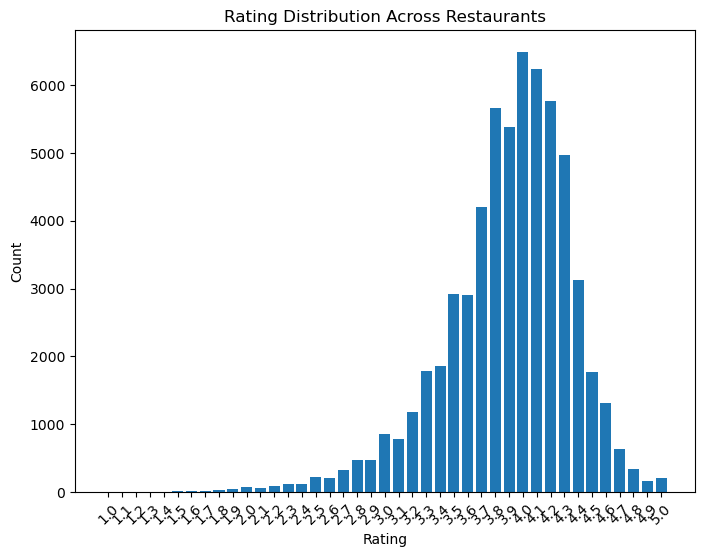

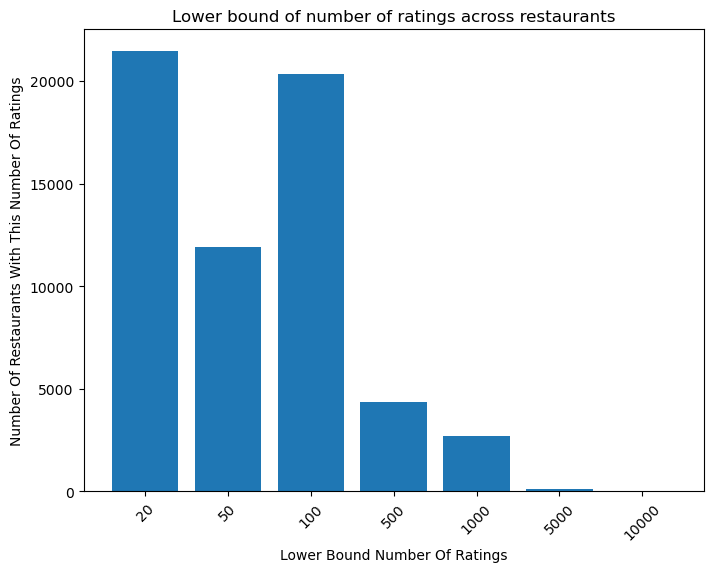

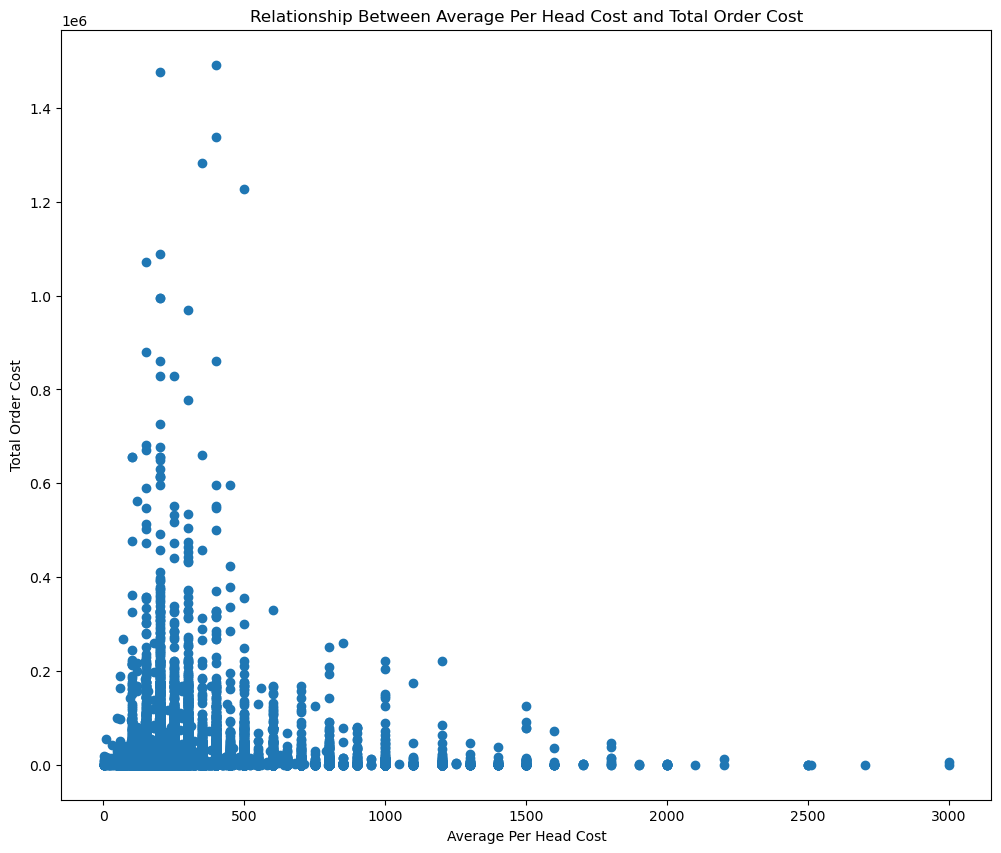

In [255]:
plot_generalized_bar(final_merged_df.groupby('r_rating').size(),
                     "Rating Distribution Across Restaurants",
                     "Rating", "Count")

plot_generalized_bar(final_merged_df.groupby('r_number_of_ratings').size(),
                     'Lower bound of number of ratings across restaurants',
                     "Lower Bound Number Of Ratings",
                     "Number Of Restaurants With This Number Of Ratings")

plot_scatter(final_merged_df['r_average_per_head_cost'],
             final_merged_df['total_order_cost'],
             "Relationship Between Average Per Head Cost and Total Order Cost",
             "Average Per Head Cost", "Total Order Cost")

**In the restaurant graphs above**, we see that most orders came from restaurants that had a rating between 3.7-4.4. Additionally, a similar amount of restaurants received 20 ratings as 100 ratings (35.2% received 20 and 33.4% received 100 ratings). Lastly, there were very few customers that ordered from restaurants with an average per head cost that was greater than 550. 

It's important to note that this graph mostly follows a log shape. In our subsequent analyses, we will use the data as is, but we may take the log of the average per head cost to increase model performance. 

## Statistical Analysis and Modeling
We will apply linear regression models to test our hypotheses. This section will include the implementation of these models and the interpretation of their results.

### Define Functions:

In [256]:
def calculate_vif(df, drop, drop_one_hot):
    df = df.drop(columns=drop)
    df = df.drop(columns=drop_one_hot)
    df = df.apply(pd.to_numeric, errors='coerce').dropna()
    X = sm.add_constant(df)
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

In [257]:
def cross_validation(X, Y, test_size=0.3, n_splits=10, random_state=42):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                        test_size=test_size,
                                                        random_state=random_state)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    rmse_scores = []
    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        Y_train_fold, Y_test_fold = Y_train.iloc[train_index], Y_train.iloc[test_index]
        model = sm.OLS(Y_train_fold, X_train_fold)
        results = model.fit()
        Y_pred_fold = results.predict(X_test_fold)
        rmse = np.sqrt(mean_squared_error(Y_test_fold, Y_pred_fold))
        rmse_scores.append(rmse)

    average_rmse = np.mean(rmse_scores)
    print("Average RMSE:", average_rmse)

We made a VIF function to check for multicolinearity between variables. The goal is to use this function to check whether VIF is close to 1 and therefore whether it appears safe to proceed with our linear regression.
We also made a cross validation function to check how well our model performs. It is important to check that our RMSE is low, so that we have better certainty around the trustworthiness of our model.

To summarize, in the sections below, we will use these function to check for multicolinearity and how low our RMSE is.

### Tests for Hypothesis 1: Predicting Order Cost Based on Customer Demographics:

**Research Question**: How do various customer demographics collectively predict the total order cost?

**Predictor Variables**:'c_age', 'c_gender', 'c_family_size', 'c_marital_status_', 'c_occupation_', 'c_monthly_income_', 'c_education_level_'.

In [258]:
X1 = final_merged_df[['c_age', 'c_gender','c_monthly_income',
                      'c_family_size','c_marital_status_Married',
                      'c_marital_status_Prefer not to say',
       'c_marital_status_Single', 'c_occupation_Employee',
       'c_occupation_House wife', 'c_occupation_Self Employeed',
       'c_occupation_Student', 'c_education_level_Graduate',
       'c_education_level_Ph.D', 'c_education_level_Post Graduate',
       'c_education_level_School', 'c_education_level_Uneducated']]
Y1 = final_merged_df[['total_order_cost']]
X1 = sm.add_constant(X1)

#### Multicolinearity Test:
We will now perform a Multicolinearity test to check for colinearity between our variables.

In [259]:
print(calculate_vif(final_merged_df, ['total_order_cost', 'order_id', 'order_date',
                                      'currency', 'c_id', 'r_id', 'c_name', 'r_name',
                                      'r_city'], ['c_marital_status_Single',
                                                  'c_occupation_Student',
                                                  'c_education_level_Uneducated' ]))

                               Feature         VIF
0                                const  457.501900
1                 number_items_ordered    1.000465
2                                c_age    2.364767
3                             c_gender    1.117628
4                     c_monthly_income    3.396139
5                        c_family_size    1.101355
6                             r_rating    1.031343
7                  r_number_of_ratings    1.010541
8              r_average_per_head_cost    1.021074
9             c_marital_status_Married    2.244452
10  c_marital_status_Prefer not to say    1.182199
11               c_occupation_Employee    3.265517
12             c_occupation_House wife    1.904158
13         c_occupation_Self Employeed    2.671747
14          c_education_level_Graduate   55.467301
15              c_education_level_Ph.D   13.623844
16     c_education_level_Post Graduate   55.746520
17            c_education_level_School    7.141618


Here, we see that the VIF values are close to one, with the exception of the variables associated with education (c_education_level_Graduate, c_education_level_Ph.D, c_education_level_Post Graduate, c_education_level_School). We will address this later by grouping these variables into one variable. Aside from those variables, there does not appear to be colinearity between variables and we will process with our linear regression.

#### OLS

This is our first OLS to test our Hypothesis 1:

In [260]:
model = sm.OLS(Y1,X1)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       total_order_cost   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8764
Date:                Mon, 04 Dec 2023   Prob (F-statistic):              0.578
Time:                        23:44:55   Log-Likelihood:            -7.1754e+05
No. Observations:               60857   AIC:                         1.435e+06
Df Residuals:                   60843   BIC:                         1.435e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

#### Residual Analysis

We will now conduct a residual analysis. Based on the variance in the graph, we will have a better idea of the strength of our regression and subsequent analysis.

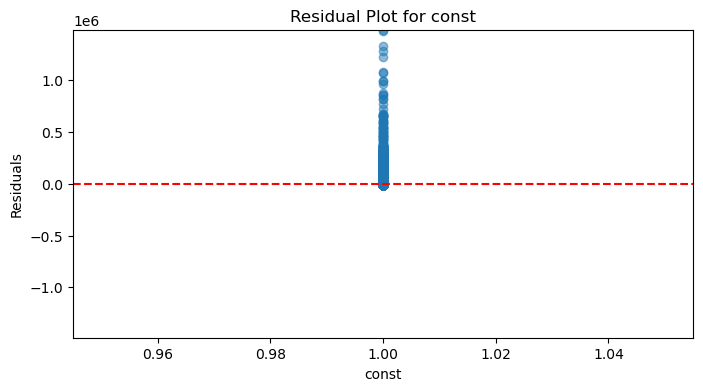

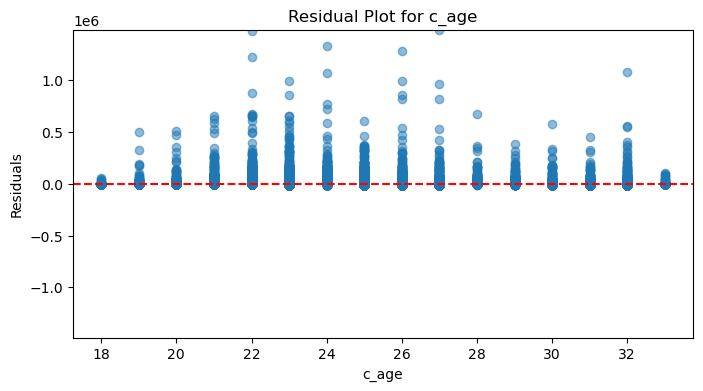

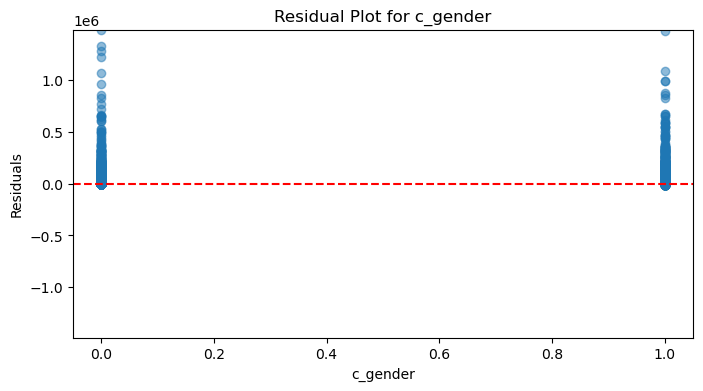

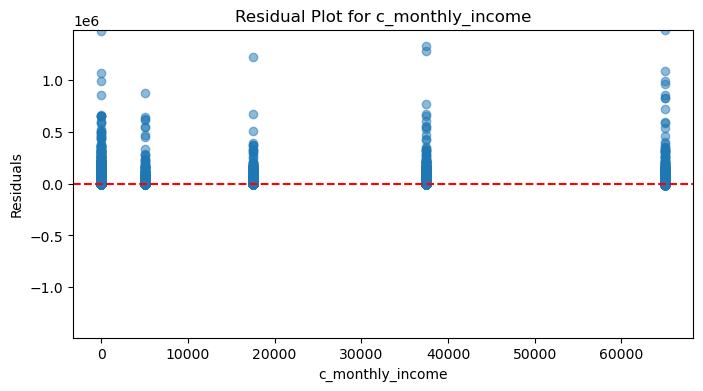

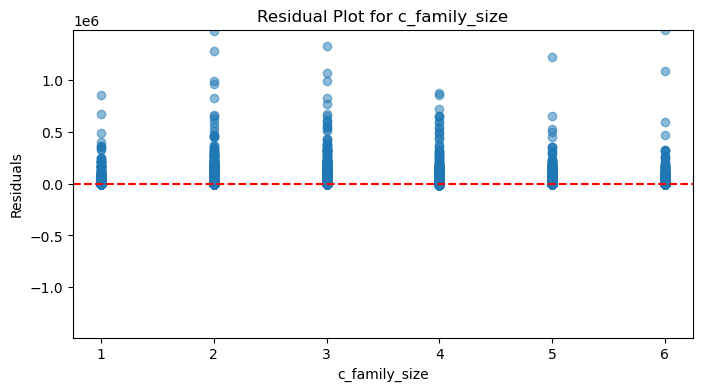

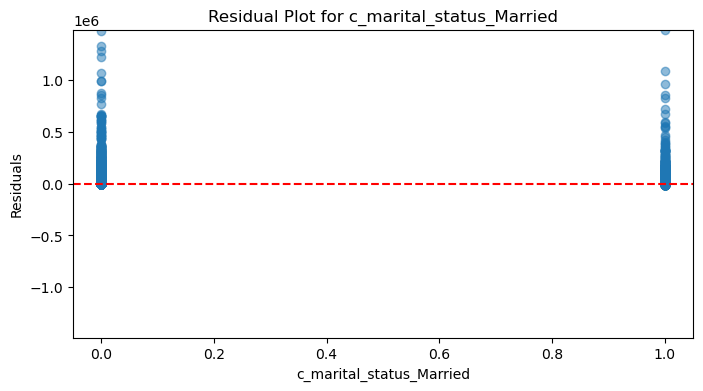

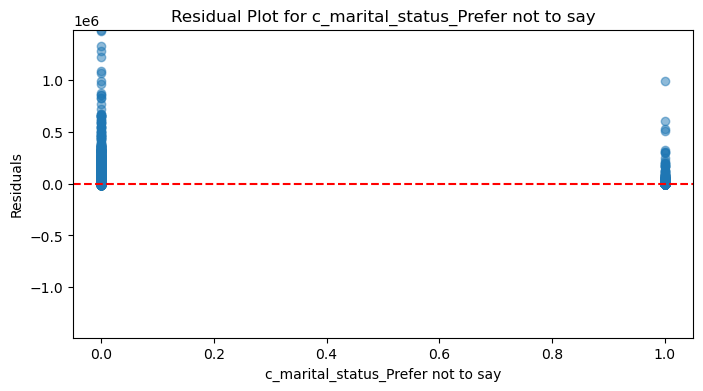

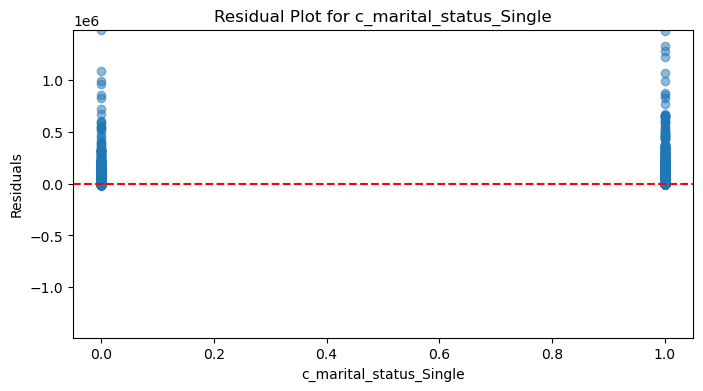

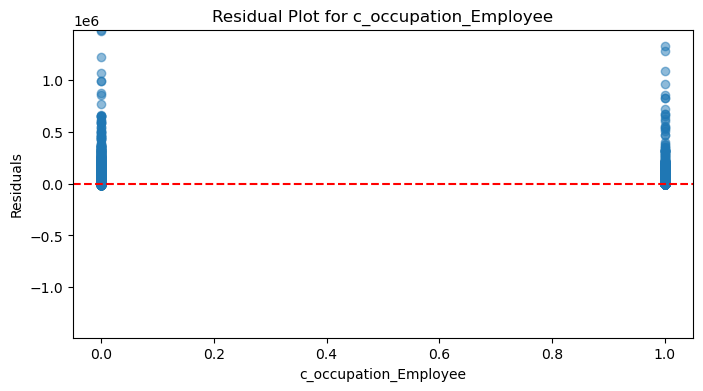

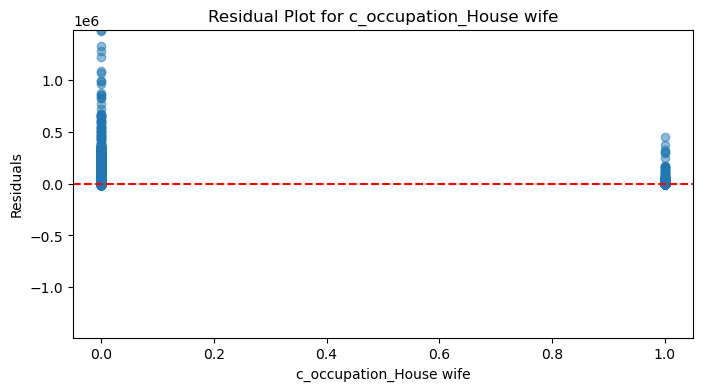

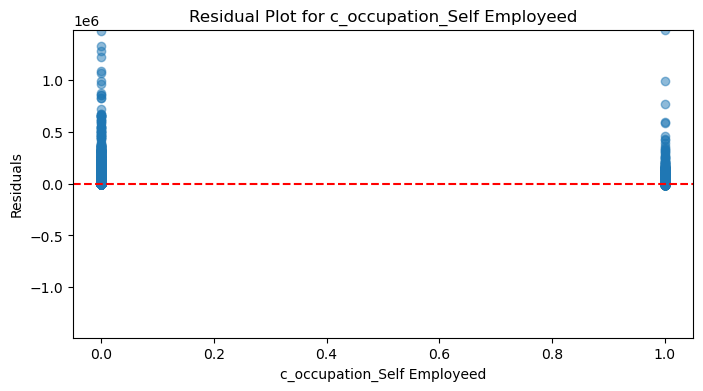

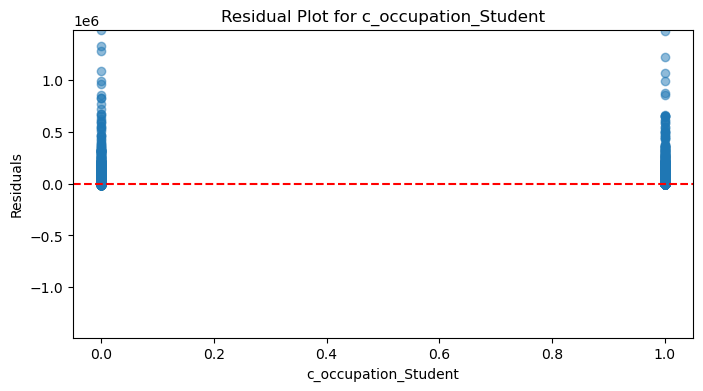

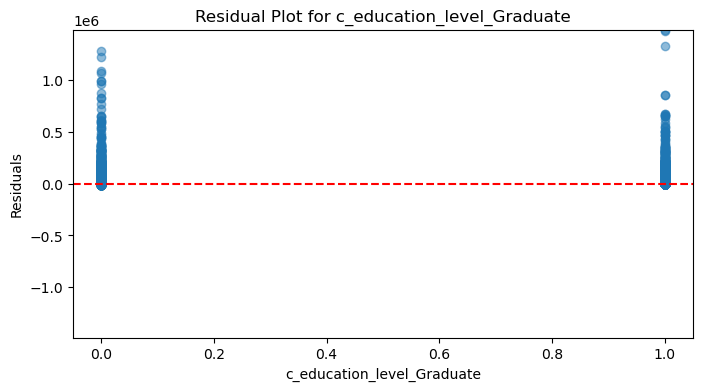

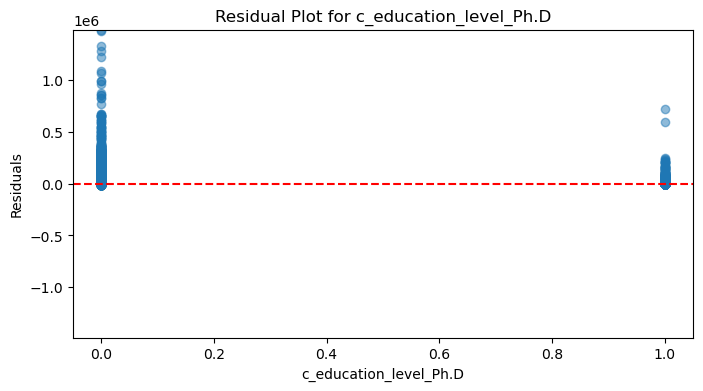

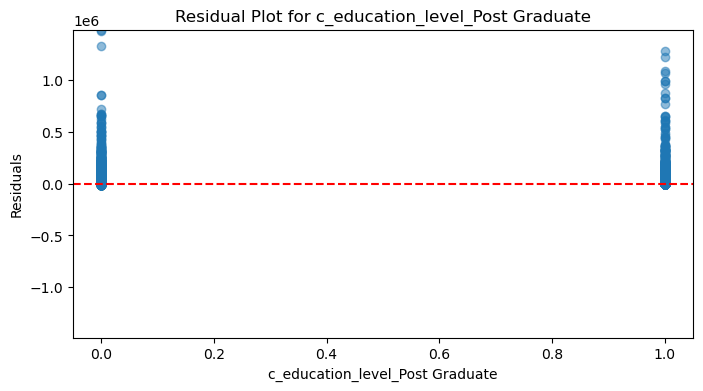

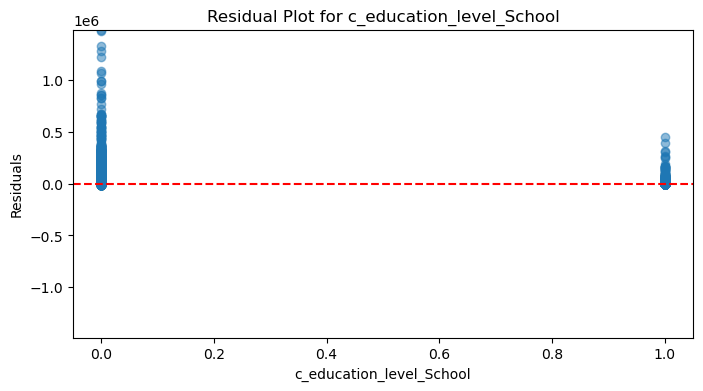

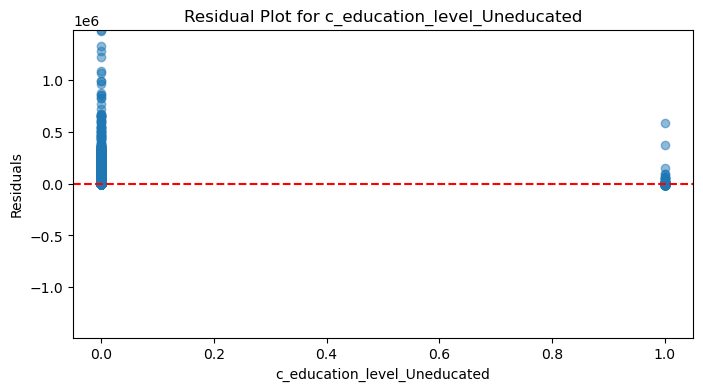

In [261]:
residuals1 = results.resid
max_residual1 = max(abs(residuals1))
for column in X1.columns:
    plt.figure(figsize=(8, 4))
    plt.scatter(X1[column], residuals1, alpha=0.5)
    plt.title(f'Residual Plot for {column}')
    plt.xlabel(column)
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.ylim(-max_residual1, max_residual1)
    plt.show()


Based on the residuals above, our regression does not appear to be very strong. We can see this in the way that the residuals are scatterd above the x axis, meaning that there does not appear to be much constant variance. We will now use our cross validation function to check our RMSE value and analyze further whether adjustments need to made to our model.

### Cross Validation:

In [262]:
cross_validation(X1, Y1, test_size=0.3, n_splits=10, random_state=42)

Average RMSE: 31932.369860093935


This RMSE is extremely large, suggesting that our model needs adjusting.

### Fixing Model:

Due to the weird shape of the residual graphs, and the overwhelmingly large RMSEs, we are now going to look at the distribution of positive vs negative residuals, and the respective magnitudes of each groups.


In [263]:
negative_count = np.sum(residuals1 < 0)
positive_count = np.sum(residuals1 > 0)

mean_negative = np.mean(residuals1[residuals1 < 0])
mean_positives = np.mean(residuals1[residuals1 > 0])

part1 = "The number of residuals below 0"
part2 = "the mean residual value"
print(f"{part1} is: {negative_count} and {part2} is: {mean_negative}")
print(f"{part1} is: {positive_count} and {part2} is: {mean_positives}")


The number of residuals below 0 is: 51201 and the mean residual value is: -5911.429556911854
The number of residuals below 0 is: 9656 and the mean residual value is: 31345.39195769444


This output indicates that there are many more negative residuals than positive ones. However the magnitude of those that are positive dwarf that of the negative ones, explaining why the residuals seem so positive. Because of this, we are going to follow the same exact process as before, however we will apply a logarithm to the output variable now to see if this makes a difference in our model. Typically, applying a log scale can help normalize extremes that seem to be happening here.

In [264]:
X1 = final_merged_df[['c_age', 'c_gender','c_monthly_income',
                      'c_family_size','c_marital_status_Married',
                      'c_marital_status_Prefer not to say',
       'c_marital_status_Single', 'c_occupation_Employee',
       'c_occupation_House wife', 'c_occupation_Self Employeed',
       'c_occupation_Student', 'c_education_level_Graduate',
       'c_education_level_Ph.D', 'c_education_level_Post Graduate',
       'c_education_level_School', 'c_education_level_Uneducated']]
Y1 = np.log(final_merged_df[['total_order_cost']])
X1 = sm.add_constant(X1)

In [265]:
model = sm.OLS(Y1,X1)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       total_order_cost   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.237
Date:                Mon, 04 Dec 2023   Prob (F-statistic):              0.245
Time:                        23:44:57   Log-Likelihood:            -1.2595e+05
No. Observations:               60857   AIC:                         2.519e+05
Df Residuals:                   60843   BIC:                         2.521e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

#### We will now check whether our residuals look better for this new regression:

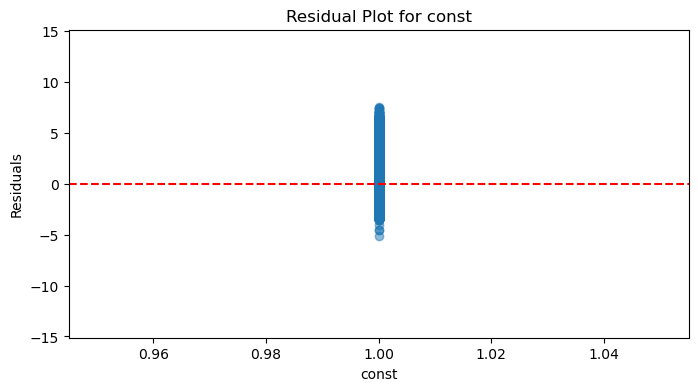

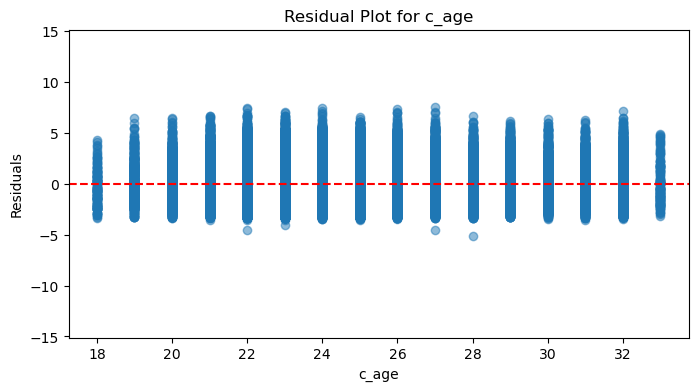

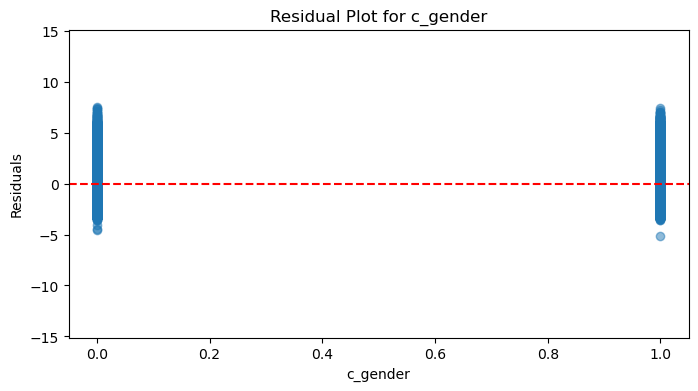

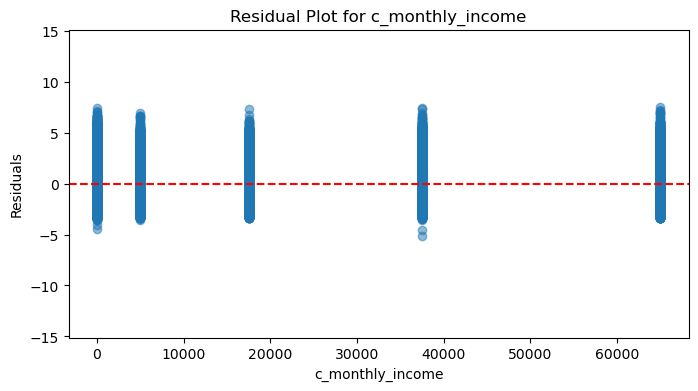

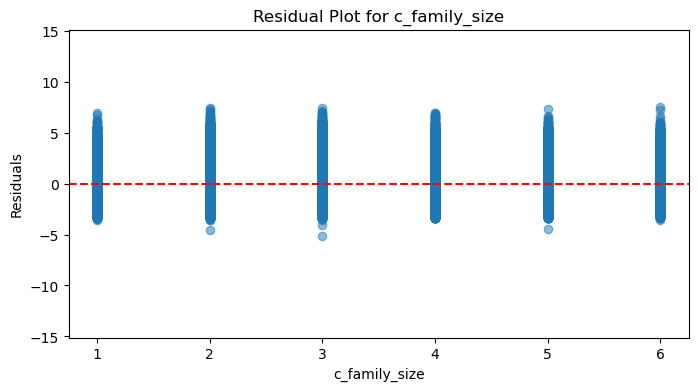

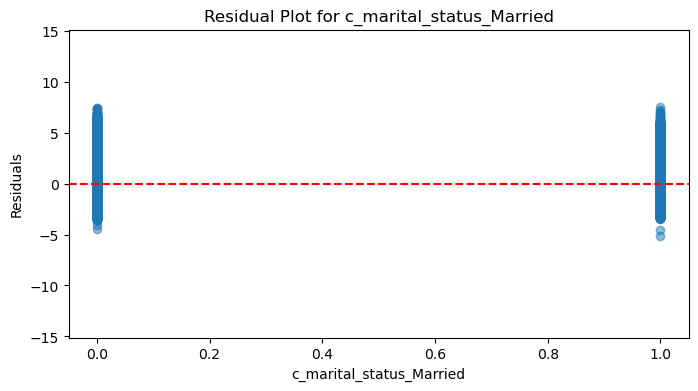

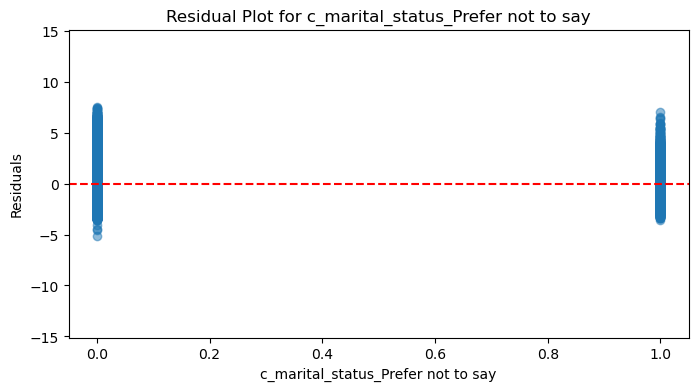

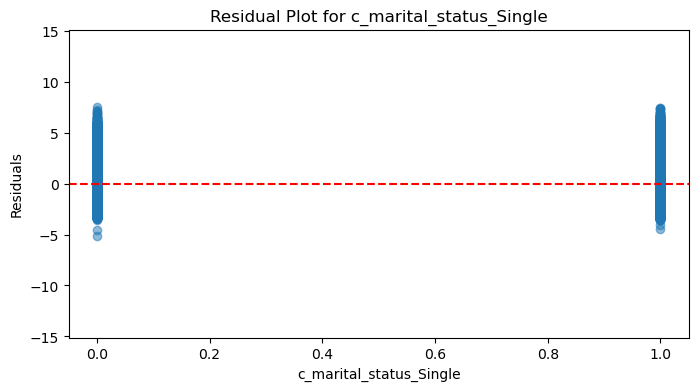

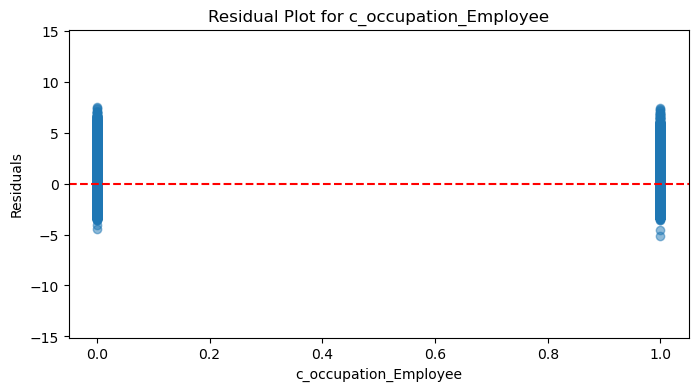

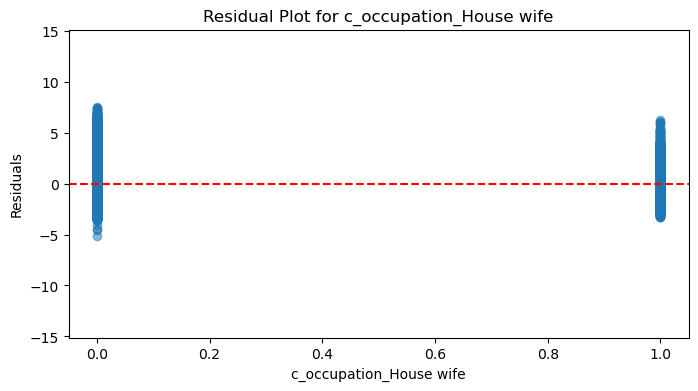

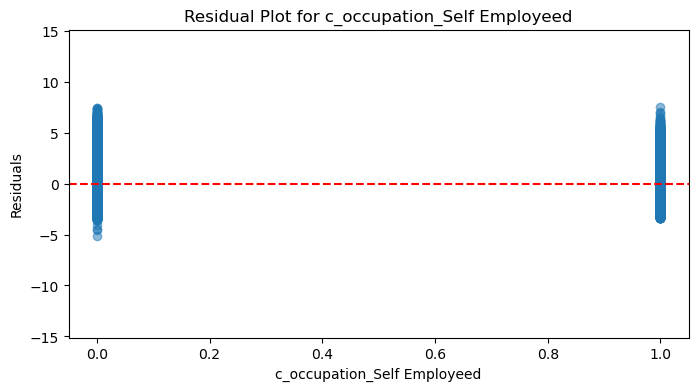

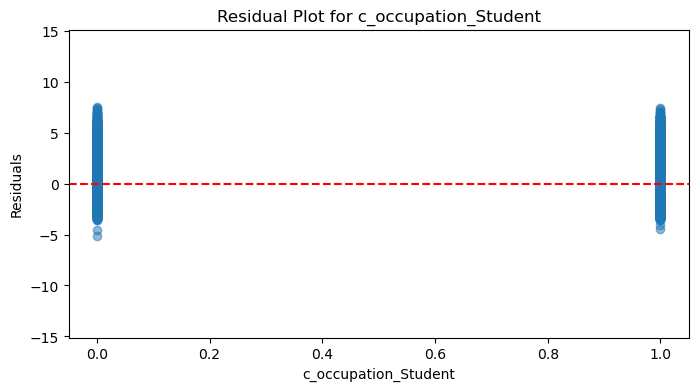

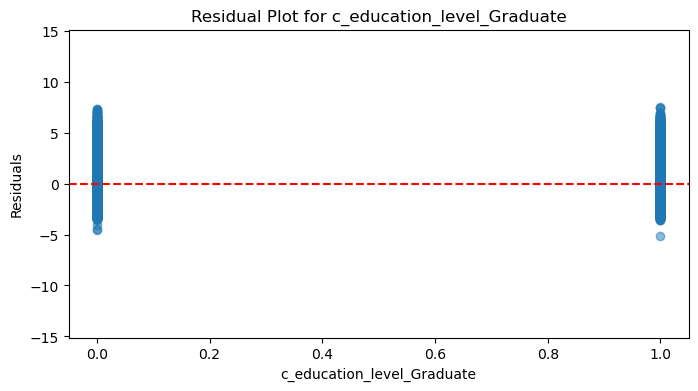

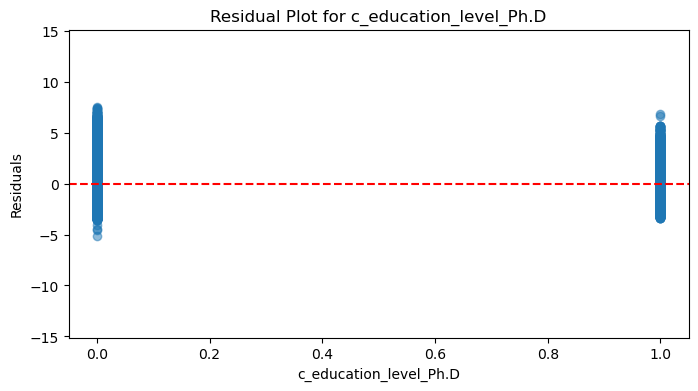

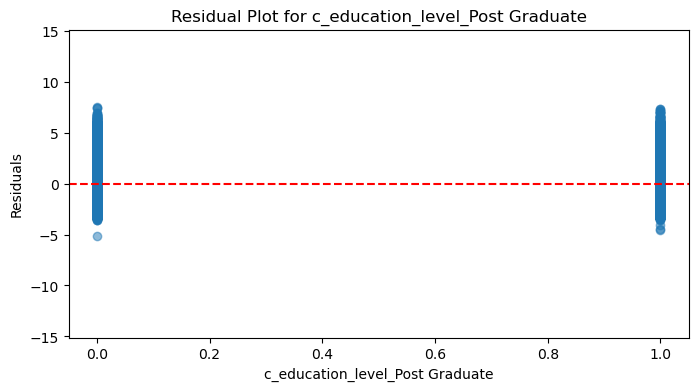

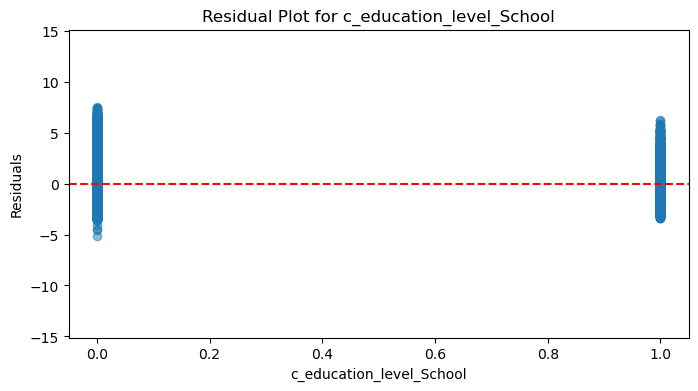

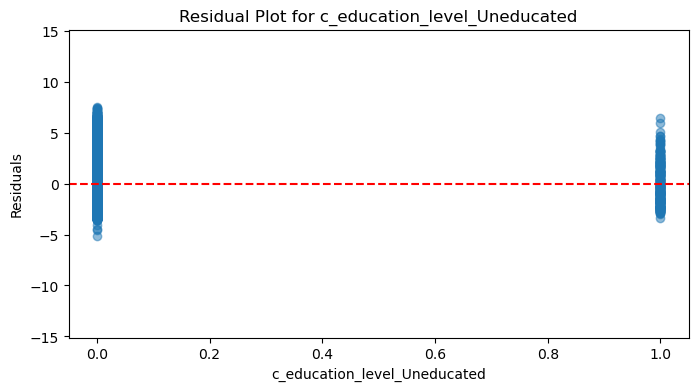

In [266]:
residuals1 = results.resid
max_residual1 = max(abs(residuals1))
for column in X1.columns:
    plt.figure(figsize=(8, 4))
    plt.scatter(X1[column], residuals1, alpha=0.5)
    plt.title(f'Residual Plot for {column}')
    plt.xlabel(column)
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.ylim(-2* max_residual1, 2*max_residual1)
    plt.show()

These residuals look much better than before and are more suggestive of constant variance. We see this in the way that each grouping of points is distributed more evenly across the x axis and sparse on the edges. Now let's check if our RMSE lowered, as well.

In [267]:
cross_validation(X1, Y1, test_size=0.3, n_splits=10, random_state=42)

Average RMSE: 1.9181535594988812


This RMSE is significantly lower. Whereas before, our RMSE was close to 30,000, it is now close to 1. Therefore we see that this new regression with the log of the outcome variable is a much better model. Now we will attempt to lower our RMSE even further.

#### Lowering The RMSE:

In [268]:
final_merged_df['Combined_Education'] = final_merged_df[['c_education_level_Graduate',
                                                         'c_education_level_Ph.D',
                                                         'c_education_level_Post Graduate']].max(axis=1)

X1 = final_merged_df[['c_age', 'c_gender', 'c_monthly_income', 'c_family_size', 
                      'c_marital_status_Married', 'c_marital_status_Prefer not to say', 
                      'c_occupation_Employee', 'c_occupation_House wife', 
                      'c_occupation_Self Employeed', 'Combined_Education']]
X1 = sm.add_constant(X1)

model = sm.OLS(Y1, X1)
results = model.fit()

cross_validation(X1, Y1, test_size=0.3, n_splits=10, random_state=42)

Average RMSE: 1.9181038965716435


Above we combined the high VIF variables into a merged column called combined_education. So if someone is a PhD or a graduate, they will fall into the same "combined_education" category. This is because of our observation noted earlier, stating that the variables associated with education had a very high VIF. 

We therefore didn't include the other education levels variables in the analysis. While a marginal difference, this combining of high VIF columns seems to lower the RMSE consistently. Now let's do a new OLS with this transformed data.

#### New OLS

In [269]:
model = sm.OLS(Y1,X1)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       total_order_cost   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.514
Date:                Mon, 04 Dec 2023   Prob (F-statistic):              0.127
Time:                        23:44:59   Log-Likelihood:            -1.2595e+05
No. Observations:               60857   AIC:                         2.519e+05
Df Residuals:                   60846   BIC:                         2.520e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

### Tests for Hypothesis 2: Restaurant Characteristics and Order Cost:

**Research Question**: How do restaurant characteristics impact the total order cost when accounting for multiple variables simultaneously?

**Predictor Variables**: 'r_rating', 'r_average_per_head_cost', 'r_number_of_ratings_*'.

In [270]:
X2 = final_merged_df[['r_rating','r_number_of_ratings',
                      'r_average_per_head_cost']]
Y2 = final_merged_df['total_order_cost']
X2 = sm.add_constant(X2)

We will now conduct a multicolinearity test to check the VIF values of our variables.

#### Multicolinearity Test:

In [271]:
vif_data = pd.DataFrame()
vif_data["feature"] = X2.columns
vif_data["VIF"] = [variance_inflation_factor(
    X2.values, i) for i in range(X2.shape[1])]
print(vif_data)

                   feature        VIF
0                    const  73.280007
1                 r_rating   1.031104
2      r_number_of_ratings   1.010458
3  r_average_per_head_cost   1.020851


Based on the findings in the multicolinearity test, given that the VIF values are low (close to 1), we see that there is low multicolinearity amongst the variables and we can process with our regression.

#### OLS:

In [272]:
model = sm.OLS(Y2,X2)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       total_order_cost   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     13.35
Date:                Mon, 04 Dec 2023   Prob (F-statistic):           1.05e-08
Time:                        23:44:59   Log-Likelihood:            -7.1752e+05
No. Observations:               60857   AIC:                         1.435e+06
Df Residuals:                   60853   BIC:                         1.435e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1

#### Residual Analysis

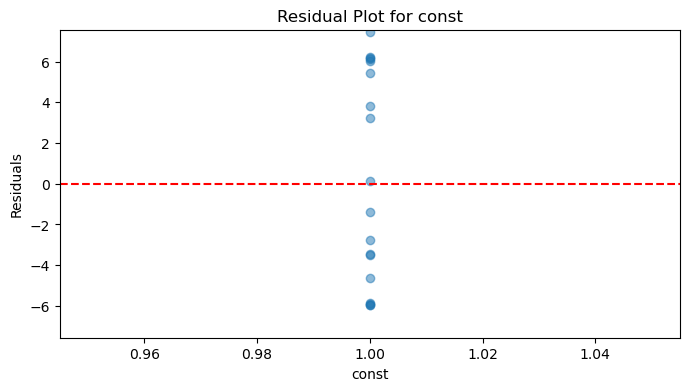

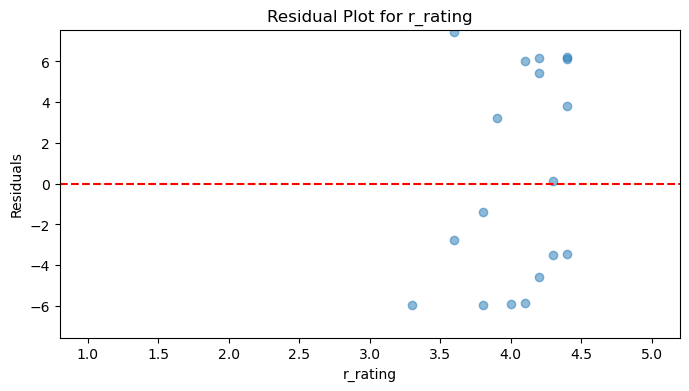

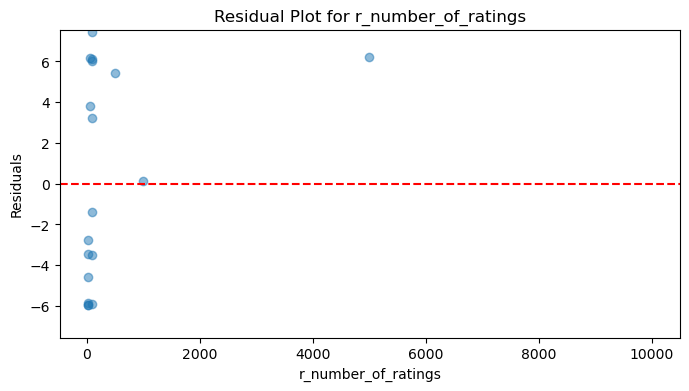

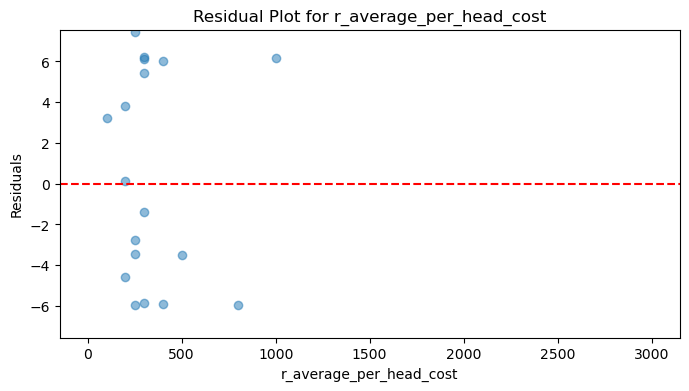

In [273]:
residuals2 = results.resid
max_residual2 = max(abs(residuals2))
for column in X2.columns:
    plt.figure(figsize=(8, 4))
    plt.scatter(X2[column], residuals2, alpha=0.5)
    plt.title(f'Residual Plot for {column}')
    plt.xlabel(column)
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.ylim(-max_residual1, max_residual1)
    plt.show()

The residuals appear to have some constant variance, as they are scattered somewhat evenly across the axis. Now let's use our cross validation test to check the RMSE of the model.

#### Cross Validation

In [274]:
cross_validation(X2, Y2, test_size=0.3, n_splits=10, random_state=42)

Average RMSE: 31918.857080612488


This RMSE is extremely high suggesting that we need to suggest our model. Like in Hypothesis 1, we will apply the log function to our outcome variable 'total_order_cost' to see if this helps our model perform better.

In [275]:
X2 = final_merged_df[['r_rating','r_number_of_ratings',
                      'r_average_per_head_cost']]
Y2 = np.log(final_merged_df['total_order_cost'])
X2 = sm.add_constant(X2)

#### New OLS:

In [276]:
model = sm.OLS(Y2,X2)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       total_order_cost   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     21.44
Date:                Mon, 04 Dec 2023   Prob (F-statistic):           7.08e-14
Time:                        23:45:00   Log-Likelihood:            -1.2592e+05
No. Observations:               60857   AIC:                         2.519e+05
Df Residuals:                   60853   BIC:                         2.519e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

#### Residual Analysis

Now we will conduct another residual analysis to see the strength of our model.

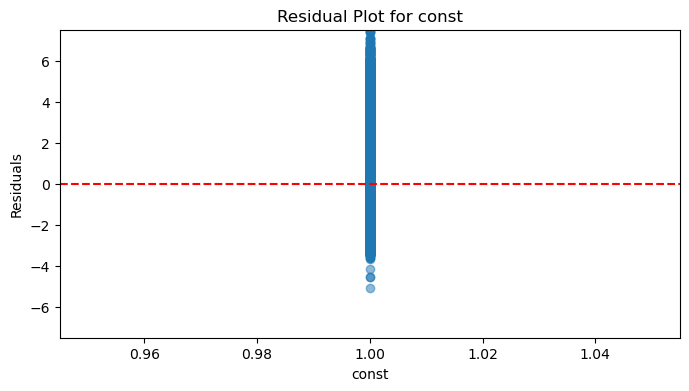

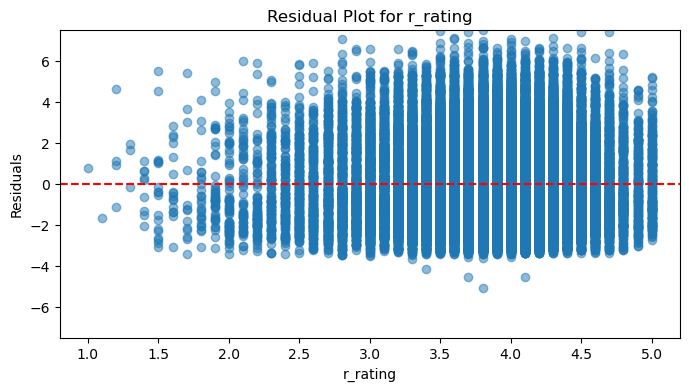

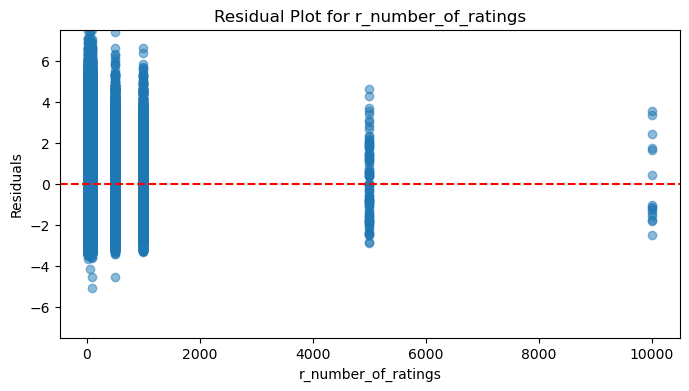

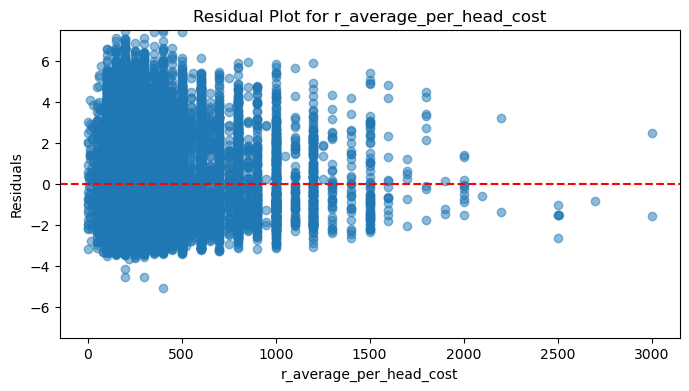

In [277]:
residuals2 = results.resid
max_residual2 = max(abs(residuals2))

for column in X2.columns:
    plt.figure(figsize=(8, 4))
    plt.scatter(X2[column], residuals2, alpha=0.5)
    plt.title(f'Residual Plot for {column}')
    plt.xlabel(column)
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.ylim(-max_residual2, max_residual2)
    plt.show()

These residuals mostly have constant variance, as they are mostly spread evenly across the x axis. The one exception is in averge per head cost, where there appears to be a slight fanning effect. We will check our cross validation and then asses whether we should change our model to account for this.

### Cross Validation:

In [278]:
cross_validation(X2, Y2, test_size=0.3, n_splits=10, random_state=42)

Average RMSE: 1.9170187690598965


This RMSE is much lower than the RMSE in the original OLS (which was close to 30,000). We therefore see that this model is much stronger. Now let's try to lower it even further. We will do this by applying log to average per head cost. As noted much earlier in our Exploratory Data Analysis, our r_average_per_head_cost has a slight logarithmic shape. To improve our RMSE, we will try to transform r_average_per_head_cost by applying the log function to it.

### Improving RMSE

In [279]:
X2['r_average_per_head_cost'] = np.log(final_merged_df['r_average_per_head_cost'])

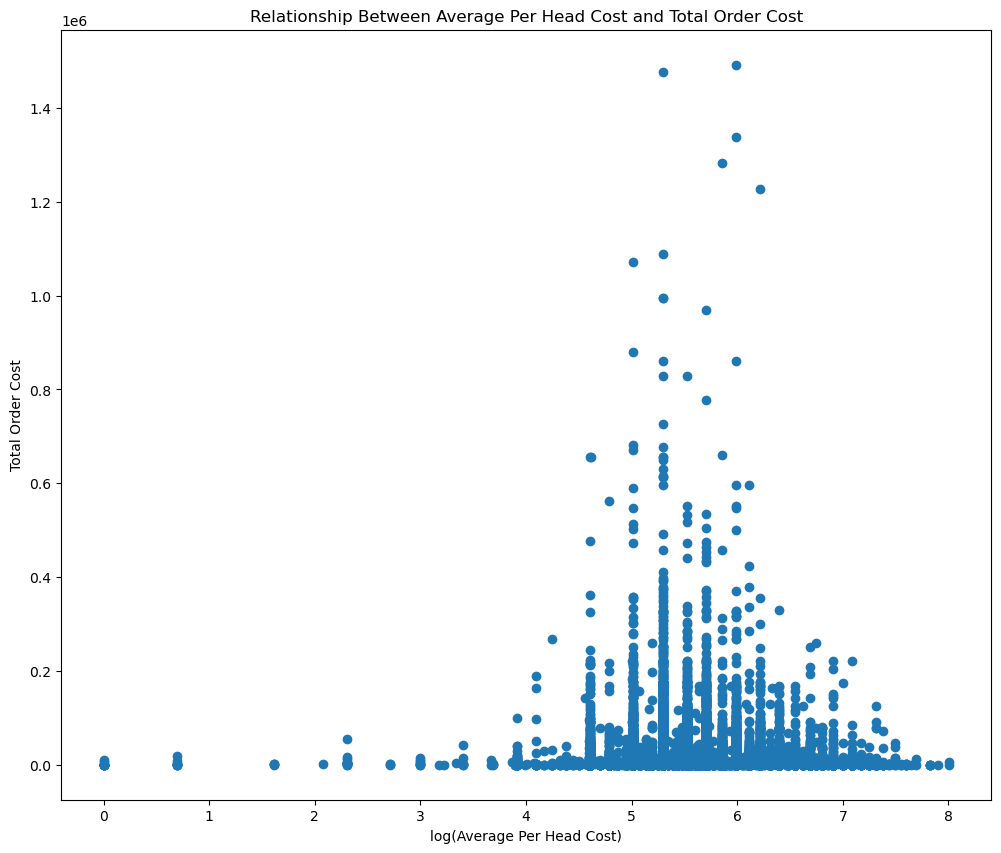

In [280]:
plot_scatter(np.log(final_merged_df['r_average_per_head_cost']),
             final_merged_df['total_order_cost'],
             "Relationship Between Average Per Head Cost and Total Order Cost",
             "log(Average Per Head Cost)", "Total Order Cost")

This new graph with the log of r_average_per_head_cost is much more evenly distributed (no longer has a logarithmic shape).

#### New Cross Validation

In [281]:
cross_validation(X2, Y2, test_size=0.3, n_splits=10, random_state=42)

Average RMSE: 1.9169611207349349


We see here that our RMSE lowered from 1.9170187690598965 to 1.9169611207349349, therefore this model with the log of r_average_per_head_cost is stronger. We will therefore conduct a new OLS with this transformation:

#### New OLS

In [282]:
model = sm.OLS(Y2,X2)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       total_order_cost   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     22.20
Date:                Mon, 04 Dec 2023   Prob (F-statistic):           2.32e-14
Time:                        23:45:01   Log-Likelihood:            -1.2592e+05
No. Observations:               60857   AIC:                         2.519e+05
Df Residuals:                   60853   BIC:                         2.519e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

## Evaluation of Significance
This section will present the findings from our statistical analyses and discuss them in the context of our research questions.
    
### For Hypothesis 1

**Demographic Factors**
- Age (c_age): A beta coefficient of .0067 (p = 0.093) suggests that there is barely any association between age and order cost.
- Gender (c_gender): The beta of .0156 (p = 0.342) indicates that being male (coded as 1) might be associated with an extremely slight increase in order costs, although this is not statistically significant. Given how small the beta is however, this correlation does not seem important.
- Monthly Income (c_monthly_income): With a negative beta of -2.651e-07 (p = 0.644), higher income levels correlate with an extremely small decrease in spending, yet this result is not statistically significant and should be considered with the caveat of the income categories' arbitrariness. For example, 5000 rupees as a marker for someone makes less than 10,000 is not precise.
- Family Size (c_family_size): The negative beta of -0.0076 (p = 0.203) suggests that larger family sizes might be associated with a very slight decrease in order costs, but this finding is not statistically significant.

**Marital Status**
- Married (c_marital_status_Married): A negative beta of -0.0172 8 (p = 0.503) indicates married individuals may spend slightly less, although this is not statistically significant.
- Prefer Not to Say (c_marital_status_Prefer not to say): With a beta of 0.0727 (p = 0.131), customers who prefer not to disclose their marital status spend very slightly more on their orders. This is also not statistically significant.

**Occupation**
- Employee (c_occupation_Employee): The negative beta of -0.0118 (p = 0.686) suggests that employees spend slightly less on Zomato orders, but this is also not statistically significant. 
- Self Employed (c_occupation_Self Employeed): A negative beta of  -0.0431 (p =  0.221), although not statistically significant, suggests that self-employed individuals might spend slightly less.

**Education Level**

- Combined Education (Combined_Education): A negative beta of -0.1214 (p = 0.020 ), this is our only statistically significant variable. This suggests that being more educated results in spending slightly less.

### For Hypothesis 2

- It is important to note that our regression involved the log of order cost. However, in our analysis below, we will simplify things by describing how our betas impact the order cost itself.

**r_average_head_per_cost**
- r_average_head_per_cost has a beta of -0.1015 (p = 0), suggesting that it is statistically significant and that an increase in per head cost leads to a slight decrease in the order cost. However, given the rupeses to dollar conversion and the fact that 3 rupees is virtually no money in dollars, we can assume that there is actually no impact on the average price per head on the total order cost.

**r_number_of_ratings**
- r_number_of_ratings has beta -2.329e-06 (p = 0.921). This initially implies that the number of ratings results in an extremely small decrease in order cost, though not significant. However, again, the rupees to dollar conversion actually implies that there is no impact on the number of ratings a restaurant has on the total order cost.

**r_rating**
- r_rating has a beta of -0.0760 (p = 0) is a statistically significant result, and implies that higher ratings result in slightly smaller total order costs.

**Other Insights**
- It is worth noting that both model's R-squared value were extremely low (around 0), indicating that the predictors included explain very little of the variance in total order costs. This could imply that other unexamined factors may play significant roles, or that the relationships are more complex than what a linear model can capture.

## Interpretation and Conclusion
In this final section, we will summarize the key takeaways from our analyses and suggest directions for future research.

**Interpretation**

Hypothesis 1
- The conducted analysis brings to light certain customer demographics that statistically contribute to the variation in order costs on the Zomato platform. Our only statistically significant variable was Combined_Education, with a p = .02, and a very slightly negative beta. The rest of the variables related to occupation and marital statis did not have a statistically significant impact on our order cost. So why would more educated people spend less on food orders? We could potentially attribute this to the idea that they are "smarter" about how they use their money and therefore are much more cautious about how much they are spending. It would be interesting to conduct more research on this factor, and to find out whether demographics that are well educated really do manage their money better.

Hypothesis 2
- The two statistically significant variables were r_average_head_per_cost and r_rating. Both had negative betas that were very small. Both of these findings go against our hypothesis, which suggested that both variables would cause in increase in order cost. For the rating of the restuarant, it would be expected that a higher rating would result in larger spending on the restaurant. In further analyses, it would be interesting to look at the fanciness of these restaurants, and whether the restaurants with a lower ratings were also ones with a lower cost per head.

**Conclusion**
Our findings could be valuable for Zomato’s targeted advertising campaigns, hinting at the potential for a marketing focus on less educated people. Since those that are more educated tend to spend less, it would be beneficial for Zomato to create material that target those that are not very educated. In theory, this would help them increase how much their users spend and thereby increase their revenue. This is also beneficial to restaurants themselves, as they also could target less educated individuals as a means of making more revenue.

## Limitations


**Limitations**
The model's limitations were reflected in the low R-squared value, implying that the variables included in the analysis did not comprehensively capture the factors affecting order costs. This suggests the presence of other influential factors outside the scope of the current model, such as user interface interactions, special offers, time of day, or even broader economic trends, which may provide additional explanatory power.

It is important to note that some of our variables were encoded. For example, in customer monthly income we converted income from the range (0- more than 500,000) to (0-5). These income categories have a level of arbitrariness that should be considered. Because of this, we can't exactly attribute an increase or decrease in income to an x amount of rupees in total order cost.

Another limitation in our model is that we don't know whether the education level of the customer refers to their current education status or their completion of their education (for example, is a customer that is a marked as a PhD currently in the PhD program, or already completed it?). We could most likely assume that they completed it, but it is hard to know for sure. This would impact the marketing material that Zomato puts out based on the education level/ school status of their customers.

Lastly, while we are able to see how each of these variables impact order cost individually, we are not able to predict how total order cost is impacted according to a specific list of variables (for example an educated male ordering from a 5 star restaurant.